<a target="_blank" href="https://colab.research.google.com/github/Sebelino/DD2424-project/blob/main/e1_sebastian.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
%load_ext autoreload
%autoreload 2

import os
import socket

repo_name = "DD2424-project"
dep_filename = "download_dataset.py"
cwd = os.getcwd()
hostname = socket.gethostname()

print(f"Host: {hostname}")
print(f"You are here: {cwd}")

if os.path.exists(dep_filename):
    print(f"{dep_filename} is in your current directory. Assuming you are in the root of the repository.")
elif not os.path.exists(repo_name):
    print(f"Cloning repo and fetching {dep_filename}...")
    !git clone https://github.com/Sebelino/DD2424-project
    !cp DD2424-project/download_dataset.py .
else:
    !git -C DD2424-project pull --rebase
    !cp DD2424-project/download_dataset.py .

Host: deeplearning-vm
You are here: /home/sebelino/pycharm_deployment
download_dataset.py is in your current directory. Assuming you are in the root of the repository.


# Train model

Training with params:
{
  "seed": 42,
  "batch_size": 32,
  "architecture": "resnet50",
  "optimizer": {
    "learning_rate": 0.01,
    "weight_decay": 0.0001,
    "momentum": 0.9,
    "name": "nag"
  },
  "n_epochs": 10,
  "freeze_layers": true,
  "unfreezing_epochs": [3, 6],
  "validation_freq": 1
}
Training result:
{
  "training_losses": [1.6689337611846302, 0.47329614408638165, 0.25059353301058646, 0.07627233775818477, 0.043067703486683415, 0.03103300376349817, 0.019521054802917995, 0.010683025366312864, 0.008937175521050054, 0.007392493995923914],
  "training_accuracies": [0.7146739130434783, 0.923233695652174, 0.931046195652174, 0.9847146739130435, 0.9925271739130435, 0.9942255434782609, 0.9962635869565217, 0.9993206521739131, 0.9989809782608695, 0.9989809782608695],
  "validation_accuracies": [0.8831521739130435, 0.9103260869565217, 0.9171195652173914, 0.9198369565217391, 0.936141304347826, 0.9347826086956522, 0.9429347826086957, 0.9483695652173914, 0.9456521739130435, 0.9524456

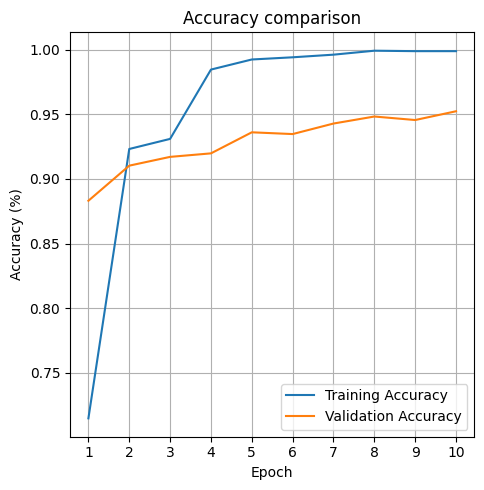

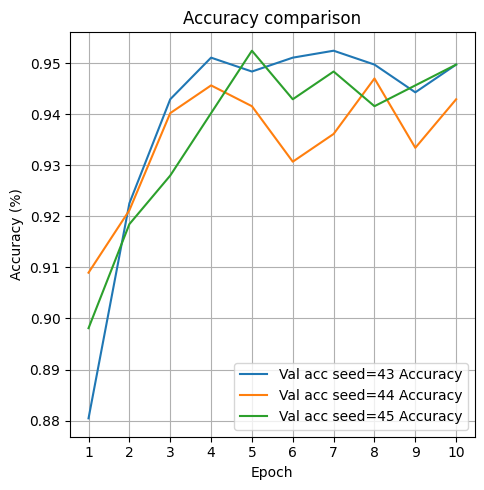

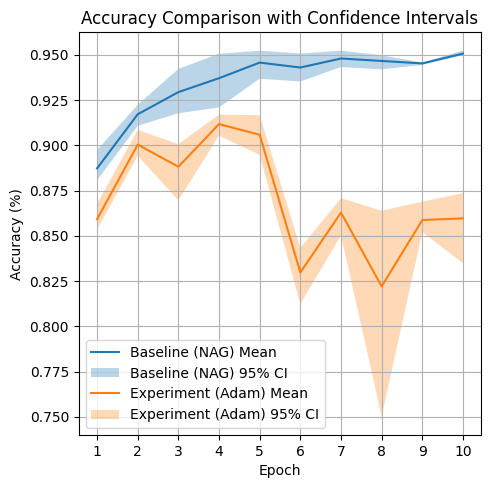

In [16]:

from dataclasses import asdict
from util import json_dumps
from evaluation import evaluate_test_accuracy_and_misclassified, \
    evaluate_with_train_val_plot, run_with_different_seeds, run_comparison
from run import run
%reload_ext autoreload
%autoreload 2

from determinism import Determinism

determinism = Determinism(seed=42).sow()  # Keep this before any torch import

from training import TrainParams, NagParams, AdamParams

baseline_params = TrainParams(
    seed=determinism.seed,
    batch_size=32,
    architecture="resnet50",
    n_epochs=10,
    optimizer=NagParams(
        learning_rate=0.01,
        weight_decay=1e-4,
        momentum=0.9,
    ),
    freeze_layers=True,
    unfreezing_epochs=(3, 6),
    validation_freq=1,
    time_limit_seconds=None,
    val_acc_target=None,
)

invalidate_cache_entry = False
if invalidate_cache_entry:
    run.call_and_shelve(baseline_params).clear()

# First plot: Training and validation accuracy
print("Training with params:")
print(baseline_params.pprint())
result = run(baseline_params)

print("Training result:")
print(result.pprint())
evaluate_with_train_val_plot(result)

# Second plot: Rerun training multiple times with different seed
run_with_different_seeds(baseline_params, trials=3)

# Third plot: Compare NAG with Adam
experimental_params = baseline_params.copy()
experimental_params.optimizer = AdamParams(learning_rate=0.001)

param_sets = {
    "Baseline (NAG)": baseline_params,
    "Experiment (Adam)": experimental_params,
}

run_comparison(param_sets, trials=3)


# Test model

In [6]:
# Currently broken

from training import Trainer
from torch.utils.data import DataLoader
from datasets import load_dataset

test_dataset = load_dataset("test", Trainer.make_transform(baseline_params))
test_loader = DataLoader(
    test_dataset,
    batch_size=baseline_params.batch_size,
    shuffle=False,
    num_workers=2,
    worker_init_fn=Determinism.data_loader_worker_init_fn(baseline_params.seed),
)
print(f"Test size: {len(test_loader.dataset)}")

evaluate_test_accuracy_and_misclassified(result, test_loader, test_dataset)


Test size: 3669


AttributeError: 'TrainingResult' object has no attribute 'trainer'